# Can you make big money on Chinese stock IPO?

**Author**: [Spark Tseung](https://sparktseung.com)

**Source Code**: [github](https://github.com/sparktseung/Chinese-IPO) 

**Last Modified**: Sept 12, 2020

## Introduction

About two years ago, I started to have some extra money for investing. After a few trial-and-errors, I have resorted to regular purchase of a low-fee Exchange Traded Fund (ETF) tracking the US market index - the cost of "beating the market" just seems too high, and an average of 7~8% per year is already a very decent return.

I have been all content with that until a friend of mine mentioned the unbelievably high return on purchasing the Initial Public Offerings (IPO) of Chinese stocks. He claimed that, if you are lucky enough to be assigned some units during an IPO, the return on the first day of public trading is quite significant (e.g. 100%+). However, it is generally quite difficult to obtain those IPOs in the first place, so it is almost like buying a lottery.

Unfamiliar with, and intentially staying away from, the Chinese stock market, I was quite suspicious at first, but a quick search on the Internet has my confidence shaken. Therefore, being a student in statistics, I naturally started to dig into a pool of data, trying to find out if one can make some big money from Chinese stock IPOs. More specifically, I would like to see if one can make profits by obtaining stocks from IPOs and then selling them shortly after the public trading starts.

## Getting the data

There are not a lot of data sources available for the issue prices of IPOs in the Chinese market. The best I can find is the `akshare` package in Python, which in turn pulls IPO data from [eastmoney](http://data.eastmoney.com/xg/xg/dxsyl.html), a Chinese stock broker. They have three datasets of IPO, `sh` for (mostly) bluechip stocks traded on the Shanghai Stock Exchange, and `zxb`/`cyb` for smaller companies traded on the Shenzhen Stock Exchange.

In [173]:
# Load required packages
import akshare as ak
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# IPO data for stocks traded on Shanghai Stock Exchange
# Mostly blue-chip stocks
ipo_shzb_df = ak.stock_em_dxsyl(market="上海主板")
# IPO data for stocks traded on Shenzhen Stock Exchange
# Mostly smaller companies
ipo_szzx_df = ak.stock_em_dxsyl(market="中小板")
ipo_szcy_df = ak.stock_em_dxsyl(market="创业板")

100%|██████████| 17/17 [00:07<00:00,  2.34it/s]


The first few rows of the data set are shown below. A quick view of the website tells that they have IPO data starting from year 2010. I will combine the three datasets, and change the column names in English. Since the datasets are frequently updated, we will focus on the decade of 2010-2019 only.

In [3]:
ipo_shzb_df.head(3)

,股票代码,股票简称,发行价,最新价,网上发行中签率,网上有效申购股数,网上有效申购户数,网上超额认购倍数,网下配售中签率,网下有效申购股数,网下有效申购户数,网下配售认购倍数,总发行数量,开盘溢价,首日涨幅,打新收益,上市日期,市场
0,605358,N立昂微,4.92,7.08,0.03197,114224888000,15990041,3127.56,0.00446855,90812500000,9112,22378.63,40580000,0.1992,0.4390,,2020-09-11,sh
1,605009,N豪悦,62.26,89.65,0.02382,100758868000,15783007,4197.76,0.01456494,18311100000,9316,6865.8,26670000,0.2000,0.4399,,2020-09-11,sh
2,605003,众望布艺,25.75,31.38,0.02346,84382582000,15347203,4261.75,0.01675539,13130100000,8208,5968.23,22000000,0.4400,0.4400,0.01,2020-09-08,sh


In [120]:
# Combine three datasets
ipo_df = pd.concat([ipo_shzb_df, ipo_szzx_df, ipo_szcy_df], ignore_index = True, sort = False)
# Rename columns in English
ipo_df.rename(columns={"股票代码": "ticker", "股票简称": "name",
                       "发行价": "price_issue", "最新价": "price_latest",
                       "网上发行中签率": "prob_online", "网上有效申购股数": "sub_size_online",
                       "网上有效申购户数": "subs_online","网上超额认购倍数": "over_online",
                       "网下配售中签率": "prob_offline", "网下有效申购股数": "sub_size_offline",
                       "网下有效申购户数": "subs_offline","网下配售认购倍数": "over_offline",
                       "总发行数量": "size_total", 
                       "开盘溢价": "list_premium", "首日涨幅": "return_firstday", 
                       "打新收益": "return_ipo", 
                       "上市日期": "list_date", "市场": "market"
                       }, inplace = True)
# The raw data are not in numeric
for i in range(2, 15):
    ipo_df.iloc[:, i] = pd.to_numeric(ipo_df.iloc[:, i])
# Filter by date: 2010-2019
ipo_df['list_date'] = pd.to_datetime(ipo_df['list_date'])
drop_idx = ipo_df[ (ipo_df['list_date'] > dt.datetime(2019, 12, 31)) ].index
ipo_df.drop(drop_idx , inplace = True)
ipo_df.dropna(inplace = True)

The combined and cleaned data set has 1942 records, and the variables are described as follows.

| Chinese          | English          | Description                                                                               |
|:------------------|:------------------|:-------------------------------------------------------------------------------------------|
| 股票代码         | ticker           | Ticker of the stock                                                                       |
| 股票简称         | name             | Name of the company                                                                       |
| 发行价           | price_issue      | Issue price (in CNY) of IPO, i.e. how much you pay per share before it goes public        |
| 最新价           | price_latest     | Latest trading price (in CNY)                                                             |
| 网上发行中签率   | prob_online      | Probability (in %) of successfully getting some IPO stocks, online application            |
| 网上有效申购股数 | sub_size_online  | Number of shares requested by potential IPO buyers, online application                    |
| 网上有效申购户数 | subs_online      | Number of potential IPO buyers, online application                                        |
| 网上超额认购倍数 | over_online      | How many people are competing for one successful online application, i.e. 1/prob_online   |
| 网下发行中签率   | prob_offline     | Probability (in %) of successfully getting some IPO stocks, offline application           |
| 网下有效申购股数 | sub_size_offline | Number of shares requested by potential IPO buyers, offline application                   |
| 网下有效申购户数 | subs_offline     | Number of potential IPO buyers, offline application                                       |
| 网下超额认购倍数 | subs_offline     | How many people are competing for one successful offline application, i.e. 1/prob_offline |
| 总发行数量       | size_total       | Total number of shares issued in IPO                                                      |
| 开盘溢价         | list_premium     | Premium (in decimal) of first-day trading, i.e. (first-day price / IPO price) - 1         |
| 首日涨幅         | return_firstday  | Price increase (in decimal) of first-day trading, i.e. (close/open) - 1 on the first day  |
| 打新收益         | return_ipo       | Return on IPO (according to some formula by eastmoney)                                    |
| 上市日期         | list_date        | Date of IPO                                                                               |
| 市场             | market           | Market of IPO                                                                             |

## A first look at the data

Let's have a look at one particular stock with ticker number 603109, which was first publicly traded on the Shanghai Stock Exchange (`market`) on the last day of 2019 (`list_date`). Before that, you can buy it at 18.38 per share (`price_issue`) by making an application, and its latest trading price is 26.48 (`price_latest`).

An average investor can get involved in its IPO through either online or offline application. For online applications, there are 12,131,674 potential subscribers who files an application (`subs_online`), and they are interested in buying 93,892,836,000 shares in total (`sub_size_online`). However, the demand is much higher than the supply, since it turns out that only 0.03515% of them (`prob_online`) actually ended up successfully getting some shares. In other words, the odds of a successful application is 1 to 2,284.98 (`over_online`). The same set of numbers for offline application are also provided. Despite a large number of interested investors, only 36,670,000 shares (`size_total`) were eventually issued.

For those who managed to get some IPO shares, they were in for a lucky treat. On the first day of trading, the stock opens at a premium of 20.02% (`list_premium`), or 22.06 per share, and it closed 44.02% (`return_firstday`) above the IPO price. The variable `return_ipo` is calculated by the eastmoney website according to their formula, so I will ignore it for the moment.

In [63]:
ipo_df.head(1)

,ticker,name,price_issue,price_latest,prob_online,sub_size_online,subs_online,over_online,prob_offline,sub_size_offline,subs_offline,over_offline,size_total,list_premium,return_firstday,return_ipo,list_date,market
54,603109,神驰机电,18.38,26.48,0.03515,93892836000,12131674,2844.98,0.011563,31714300000,7312,8648.57,36670000,0.2002,0.4402,0.03,2019-12-31,sh


## How hard is it to get some IPO shares?

Just after a first glance, we can already tell the probability of succesfully getting IPO shares is quite low. Let's look at a number of summary statistics and do some plotting.

In [121]:
# Aggregate online and offline successful rate
ipo_df['prob_all'] = ( ipo_df['prob_online'] * ipo_df['subs_online'] + ipo_df['prob_offline'] * ipo_df['subs_offline'] ) / (ipo_df['subs_online'] + ipo_df['subs_offline'] )

In [122]:
# Summary: online
ipo_df['prob_online'].describe()

count    1942.000000
mean        0.715079
std         2.146782
min         0.011570
25%         0.031745
50%         0.299550
75%         0.730685
max        65.520840
Name: prob_online, dtype: float64

In [123]:
# SummaryL offline
ipo_df['prob_offline'].describe()

count    1942.000000
mean        3.509657
std         8.398939
min         0.000000
25%         0.010545
50%         0.102908
75%         2.691333
max       100.000000
Name: prob_offline, dtype: float64

In [124]:
# Summary: overall
ipo_df['prob_all'].describe()

count    1942.000000
mean        0.715482
std         2.147102
min         0.011570
25%         0.031740
50%         0.299567
75%         0.731566
max        65.508859
Name: prob_all, dtype: float64

There are obviously some outliers, we will exclude those from our the plots. Overall, the success probabilty is overwhelmingly low. The vast majority of online applications would be uncessessful, while the odds are better in some offline cases. For an average investor, I'd consider getting a successful application as a rare event.

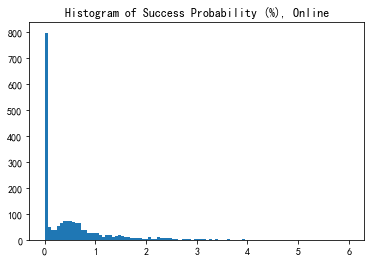

In [139]:
plt.hist(x = ipo_df['prob_online'], bins = 100, range = (0, 6));
plt.title('Histogram of Success Probability (%), Online');

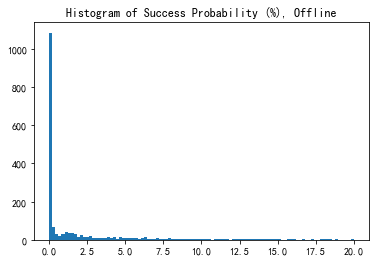

In [136]:
plt.hist(x = ipo_df['prob_offline'], bins = 100, range = (0, 20));
plt.title('Histogram of Success Probability (%), Offline');

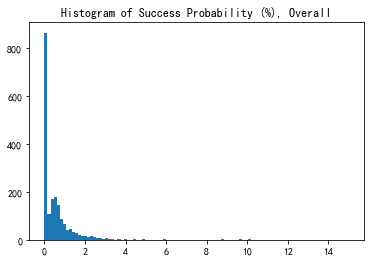

In [140]:
plt.hist(x = ipo_df['prob_all'], bins = 100, range = (0, 15));
plt.title('Histogram of Success Probability (%), Overall');

## An unexpected lesson of history

Out of curiosity, I also plotted the probabilities against the listing date of stocks. There are two noticeable gaps without any new IPO: the entire year of 2013 and the end of 2015.

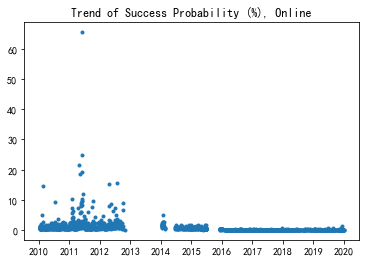

In [150]:
plt.plot_date(ipo_df['list_date'], ipo_df['prob_online'], marker = '.');
plt.title('Trend of Success Probability (%), Online');

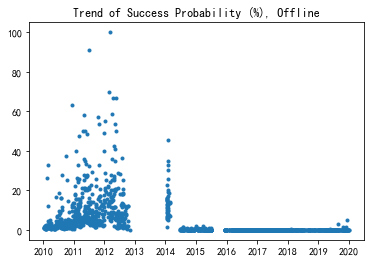

In [151]:
plt.plot_date(ipo_df['list_date'], ipo_df['prob_offline'], marker = '.');
plt.title('Trend of Success Probability (%), Offline');

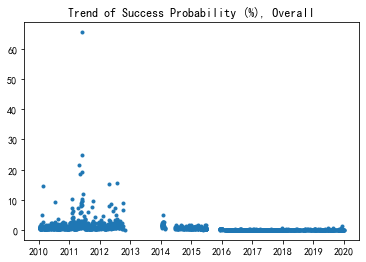

In [152]:
plt.plot_date(ipo_df['list_date'], ipo_df['prob_all'], marker = '.');
plt.title('Trend of Success Probability (%), Overall');

I suspect this might be due to the *[socialist charasteristics](https://en.wikipedia.org/wiki/Socialism_with_Chinese_characteristics)* (社会主义特色) of the Chinese capital market. After a bit of search on the Internet, I have learned a bit about the history of the Chinese stock market.

According to some news reports ([1](https://stock.gucheng.com/201606/3173448_2.shtml) and [2](http://finance.sina.com.cn/stock/y/20150704/195622592273.shtml)), there have been 9 halts of IPO in the past. What we see in the plots above are the latest two occurences.
* Nov 16, 2012 ~ Dec 30, 2013: The Chinese stock market has been declining for 3 years in a row, while western countries are recovering from the 2008 financial crisis (see [this chart of comparison](http://schrts.co/AxGcQBMZ)). The government decides to halt IPO, although there is no official statement of the rationales behind (I can't really see why).
* July 4, 2015 ~ Nov 6, 2015: The Shanghai Composite Index has dropped around 25% in just 20 days (see [this chart](http://schrts.co/RJeAxkFc)). The government halts all IPOs in an attempt to boost the market (again, I don't see why they think this would work).

There were more halts prior to these two (e.g. as you might have guessed, there was one during the financial crisis). While I will not delve into the details here, they are certainly quite interesting to read about. Such historical facts also shed lights on the influence of the government on the Chinese financial market, which contrasts the relatively freer markets in the west.

You might also have noticed that the success probabilities appear significantly lower after year 2014. I have not quite figured out why, even after a lot of search on the Internet. Never mind - I will just let this slip by and assume it probably also have something to do with government intervention. The key takeaway is that **getting shares from Chinese IPOs can be effectively considered as a rare event only for the luckiest few**. 

## Are Chinese IPOs profitable?

Now let's turn to profitability, which is actually more important. Let's assume an IPO investor sells all shares at the closing price on the first day of public trading. I will conduct the same set of analysis as above. It seems that most IPOs will generate quite attractive returns on the first day of trading. Meanwhile, there could also be a sizable loss of 20%.

In [153]:
# Summary: return
ipo_df['return_firstday'].describe()

count    1942.000000
mean        0.394821
std         0.270328
min        -0.231600
25%         0.364350
50%         0.439900
75%         0.440200
max         6.267400
Name: return_firstday, dtype: float64

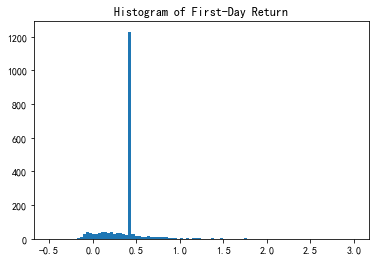

In [159]:
plt.hist(x = ipo_df['return_firstday'], bins = 100, range = (-0.5, 3));
plt.title('Histogram of First-Day Return');

There is a peak around 40% of return. The following plot of `return_firstday` against `list_date` reveals a noticeable pattern: the "magic" number of return is 44%, and almost all of them occur starting from 2014.

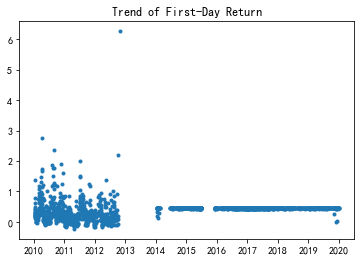

In [160]:
plt.plot_date(ipo_df['list_date'], ipo_df['return_firstday'], marker = '.');
plt.title('Trend of First-Day Return');

In [161]:
ipo_df['return_firstday'].mode()

0    0.44
dtype: float64

Again, this is due to a policy implemented by the government (see [here](https://stock.gucheng.com/201906/3742608.shtml)): trading for an IPO stock is halted after an increase of 44% (or a decrease of 36%, albeit not present in this data set) within a single day.

With this in mind, let's see which are the best-performing IPOs of the decade (obviously, they are all pre-2014). The following stocks will double the initial investment (displayed from highest to lowest return).

In [198]:
goodstock = ipo_df[ ipo_df['return_firstday'] >=1 ]
with pd.option_context('display.max_rows', None, 'display.max_columns', goodstock.shape[1]):
    print(goodstock[['ticker', 'name', 'return_firstday']].sort_values(by = ['return_firstday'], ascending = False))

ticker  name  return_firstday
982   002703  浙江世宝           6.2674
1264  002388  新亚制程           2.7533
1191  002468  申通快递           2.3504
613   603993  洛阳钼业           2.2100
1947  300239  东宝生物           1.9889
1159  002507  涪陵榨菜           1.9164
1199  002460  赣锋锂业           1.8599
1198  002461  珠江啤酒           1.7724
1193  002466  天齐锂业           1.7683
1263  002389  航天彩虹           1.7267
1268  002384  东山精密           1.6758
1144  002524  光正集团           1.6153
2078  300106  西部牧业           1.5193
1075  002600  领益智造           1.4938
1269  002383  合众思壮           1.4730
1948  300238  冠昊生物           1.4676
626   603002  宏昌电子           1.3778
1311  002338  奥普光电           1.3636
1274  002378  章源钨业           1.3046
2068  300116  坚瑞沃能           1.2788
1052  002624  完美世界           1.2393
1154  002514  宝馨科技           1.2304
1189  002471  中超控股           1.2162
2075  300109   新开源           1.2000
2112  300070   碧水源           1.2000
2082  300101  振芯科技           1.1847
1913  300272  开能健康           1.182

Meanwhile, the following stocks will yield some loss on the first day (displayed from worst return to slighly better ones). I have to say, there are not quite a lot of them.

In [199]:
badstock = ipo_df[ ipo_df['return_firstday'] <=0]
with pd.option_context('display.max_rows', None, 'display.max_columns', badstock.shape[1]):
    print(badstock[['ticker', 'name', 'return_firstday']].sort_values(by = ['return_firstday'], ascending = True))

ticker  name  return_firstday
664   601258  ST庞大          -0.2316
1028  002651  利君股份          -0.1688
2020  300165  天瑞仪器          -0.1668
1881  300305  裕兴股份          -0.1650
1906  300281  金明精机          -0.1576
1096  002577  雷柏科技          -0.1555
1849  300337  银邦股份          -0.1480
674   601700  风范股份          -0.1440
2018  300167   迪威迅          -0.1420
1131  002540  亚太科技          -0.1375
1880  300307  慈星股份          -0.1366
2019  300166  东方国信          -0.1339
658   601566   九牧王          -0.1305
1132  002539  云图控股          -0.1263
2017  300168  万达信息          -0.1214
1062  002614   奥佳华          -0.1192
1090  002583   海能达          -0.1181
1976  300209  天泽信息          -0.1179
1088  002585  双星新材          -0.1145
663   601218  吉鑫科技          -0.1124
1086  002588   史丹利          -0.1123
1031  002648  卫星石化          -0.1088
1833  300351  永贵电器          -0.1077
1907  300280  紫天科技          -0.1018
1100  002572   索菲亚          -0.1000
2101  300082  奥克股份          -0.0991
1972  300213  佳讯飞鸿          -0.098

Let's also take a look at the movement of the first-day price by plotting `return_firstday` against `list_premium`. The pattern is quite clear: if a stock opens above its IPO price, most likely it will close even higher on the first day of trading (points above the red line).

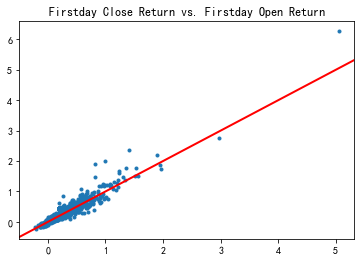

In [210]:
plt.scatter(ipo_df['list_premium'], ipo_df['return_firstday'], marker = '.');
plt.axline((0, 0), (1, 1), linewidth=2, color='r');
plt.title('Firstday Close Return vs. Firstday Open Return');

Finally, we will plot `return_firstday` against the IPO price `price_issue` and total value of issued shares `price_issue * size_total`, i.e. the market capitalization. It seems that exceptional first-day returns are mostly generated by cheaper stocks / small-cap companies.

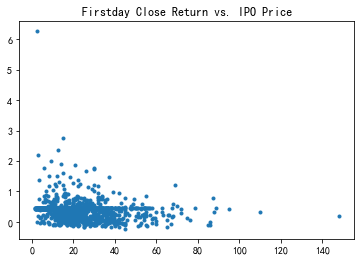

In [212]:
plt.scatter(ipo_df['price_issue'], ipo_df['return_firstday'], marker = '.');
plt.title('Firstday Close Return vs. IPO Price');

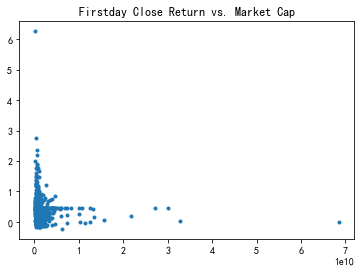

In [217]:
plt.scatter(ipo_df['price_issue']*ipo_df['size_total'], ipo_df['return_firstday'], marker = '.');
plt.title('Firstday Close Return vs. Market Cap');

The message is that **IPOs are quite profitable even if you sell it only on the first day of trading**. Anecdotal internet posts also suggest that, if the stock increases 44% on the first day, the following few trading days are very likely to be also bullish. This initial momentum certainly makes IPOs in the Chinese stock market extremely attrative, rendering them effectively "free lottery tickets" (since you will most likely end up with good profits). No wonder so many investors flock to IPOs as soon as those announcements come out! 

## Final remarks

Even though this is not a rich data set, there are certainly a lot of interesting questions to explore. For example:
* What are the 7-day, 1-year and up-to-date return of these stocks since IPO? Are people just speculating on the initial buying craze? How many of these stocks are really suitable for long-term investment?
* How about stock IPOs on the US market? I know it's a free market, and I have seen quite a number of IPOs that just drop and drop since the very first day of trading. It is definitely interesting to make a comparison between these two vastly different markets.
* Just a simple data analysis like this reveals the influence of governmemt regulations on the stock market. It could be interesting to qualitatively examine this topic (but this is beyond my strong suit).
* Unfortunately , we don't have access to more granular data sets, e.g. the size of each individual IPO application. With richer information, a more interesting study could be conducted.

Still, the simple analyses above have already answered my initial questions: **Yes, IPOs in the Chinese stock market are likely to bring you good money, but you are unlikely to get a chance in the first place** - the good old rule of supply and demand!